# Import libraries

In [1]:
Fix randomness and hide warnings
RND = False
if not RND:
    seed = 76998669

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if not RND:
    os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
if not RND:
    np.random.seed(seed)

import logging

import random
if not RND:
    random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.preprocessing.image import ImageDataGenerator

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
if not RND:
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data

In [4]:
# download clean dataset
!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_no_meme.npz

# load dataset
dataset = np.load('public_data_no_meme.npz', allow_pickle=True)
keys = list(dataset.keys())
images = np.array(dataset[keys[0]])
labels = np.array(dataset[keys[1]])

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

--2023-11-07 15:03:11--  https://storage.googleapis.com/storage.barbiero.dev/public_data_no_meme.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553413073 (528M) [application/octet-stream]
Saving to: ‘public_data_no_meme.npz’

public_data_no_meme 100%[===================>] 527.78M  25.3MB/s    in 22s     

2023-11-07 15:03:35 (23.8 MB/s) - ‘public_data_no_meme.npz’ saved [553413073/553413073]



## Split data

In [5]:
import functools

def augment_data(X,y,new_images):
  datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,)

  gen_images = new_images # Number of images that has to be generated
  for img in datagen.flow(X,y,batch_size = 1):
    if gen_images <= 0:
      break
    gen_images -= 1
    X = np.insert(X,0,img[0][0],axis=0)
    y = np.insert(y,0,img[1][0],axis=0)

  return X,y

# we are assuming positives are more than negatives and we want to equal the number of the two classes
def balance_sets(images,labels):
    negative_n = functools.reduce(lambda a, b: a+b, labels)
    print(negative_n)
    positive_n = len(images) - negative_n
    print(positive_n)
    to_add = int((positive_n - negative_n)/2)
    to_delete = to_add
    X_n = images[labels == 1]
    y_n = labels[labels == 1]
    deletable = []
    for i in range(0,to_delete):
      to_delete -= 1
      el = random.randrange(0,len(labels))
      while(labels[el] == 1 or el in deletable):
        el = random.randrange(0,len(labels))
      deletable.append(el)

    images = np.delete(images, deletable, axis=0)
    labels = np.delete(labels, deletable, axis=0)

    for i in range(0,to_add):
      to_add -= 1
      el = random.randrange(0,negative_n - 1)
      images = np.insert(images,0,X_n[el],axis=0)
      labels = np.insert(labels,0,1,axis=0)
      if to_add <= 0:
         break

    print(functools.reduce(lambda a, b: a+b, labels))
    print(len(images) - negative_n)
    return images,labels

images, labels = balance_sets(images,labels)

1903
3101
2502
3101


In [6]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size = int(0.15 * len(images)),
    **({"random_state":seed} if not RND else {}),
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = int(0.15 * len(images)),
    **({"random_state":seed} if not RND else {}),
    stratify = y_train_val
)

In [7]:
X_train, y_train = augment_data(X_train, y_train, 1500)

## Inspect data

In [8]:
# Print the shapes of the resulting sets
print('Training set shape:\t',X_train.shape, y_train.shape)
print('Validation set shape:\t',X_val.shape, y_val.shape)
print('Test set shape:\t\t',X_test.shape, y_test.shape)

Training set shape:	 (5004, 96, 96, 3) (5004,)
Validation set shape:	 (750, 96, 96, 3) (750,)
Test set shape:		 (750, 96, 96, 3) (750,)


## Process data

In [9]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")/255.
X_val = X_val.astype("float32")/255.
X_test = X_test.astype("float32")/255.

In [10]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
1    2520
0    2484
Name: class, dtype: int64


In [11]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [12]:
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [1. 0.]
"Default" label: 0


# Model

In [13]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (96, 96, 3)
Output Shape: 2


## Build model

In [14]:
def conv_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with specified filters, kernel size, and activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [15]:
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with optional batch normalization and specified activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [16]:
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [17]:
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop

    preprocessing = tfk.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(-0.7,0.7)),
        tfkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
        tfkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop'),
        tfkl.RandomFlip('vertical'),
        tf.keras.layers.RandomRotation(factor=(0,0.25)),
    ], name='preprocessing')
    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, activation=tfkl.LeakyReLU(alpha=0.05),stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, activation=tfkl.LeakyReLU(alpha=0.05),stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, activation=tfkl.LeakyReLU(alpha=0.05),stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False,activation=tfkl.LeakyReLU(alpha=0.05), stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True,activation=tfkl.LeakyReLU(alpha=0.05), stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False,activation=tfkl.LeakyReLU(alpha=0.05), stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, activation=tfkl.LeakyReLU(alpha=0.05), stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False,activation=tfkl.LeakyReLU(alpha=0.05), stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_Residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input_Layer[0][0]']         
                                                                                                  
 Conv0 (Conv2D)              (None, 96, 96, 64)           1792      ['Preprocessing[0][0]']       
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 96, 96, 64)           256       ['Conv0[0][0]']               
 tion)                                                                               

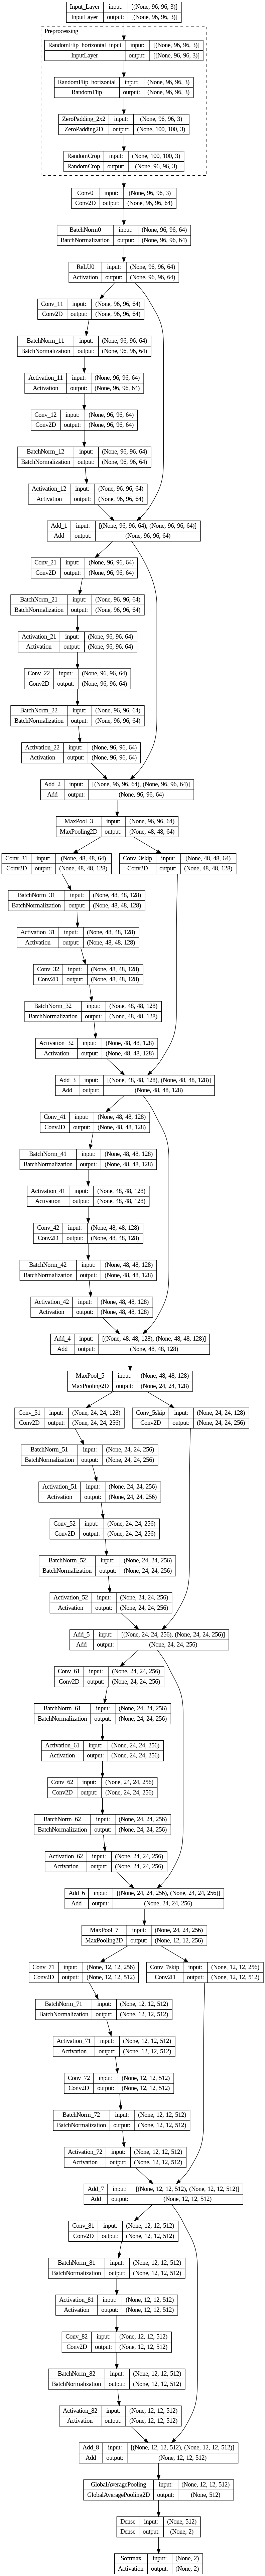

In [18]:
model = build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed)

# Print the model summary and plot the model architecture
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

## Train model

In [19]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=7,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.90,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7            # Minimum learning rate
)


callbacks = [early_stopping,lr_scheduler]

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Save the trained model
model.save('CHANGE_THIS_NAME')

Epoch 1/500
157/157 [==============================] - 59s 232ms/step - loss: 0.6600 - accuracy: 0.6855 - val_loss: 4.9070 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/500
157/157 [==============================] - 34s 214ms/step - loss: 0.5447 - accuracy: 0.7374 - val_loss: 2.6427 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/500
157/157 [==============================] - 34s 217ms/step - loss: 0.4992 - accuracy: 0.7606 - val_loss: 1.7815 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/500
157/157 [==============================] - 34s 219ms/step - loss: 0.4636 - accuracy: 0.7890 - val_loss: 0.4851 - val_accuracy: 0.7787 - lr: 1.0000e-04
Epoch 5/500
157/157 [==============================] - 36s 227ms/step - loss: 0.4221 - accuracy: 0.8054 - val_loss: 0.4790 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/500
157/157 [==============================] - 35s 224ms/step - loss: 0.4057 - accuracy: 0.8151 - val_loss: 0.5176 - val_accuracy: 0.7733 - lr: 1.0000e-04
Epoch 7/500
157/157 [=

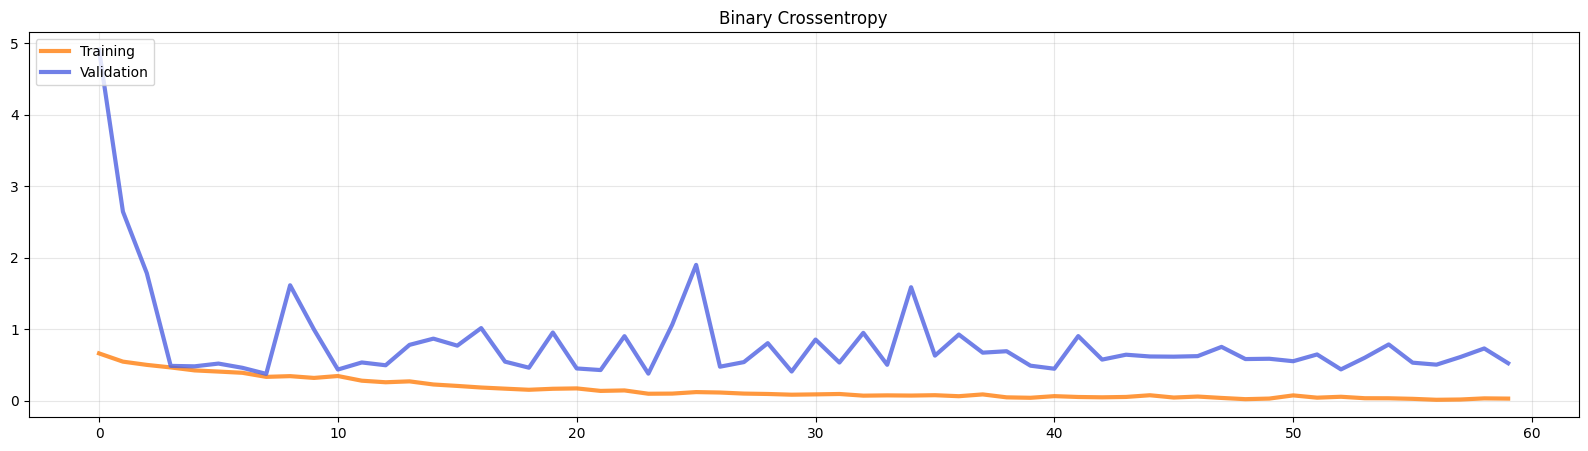

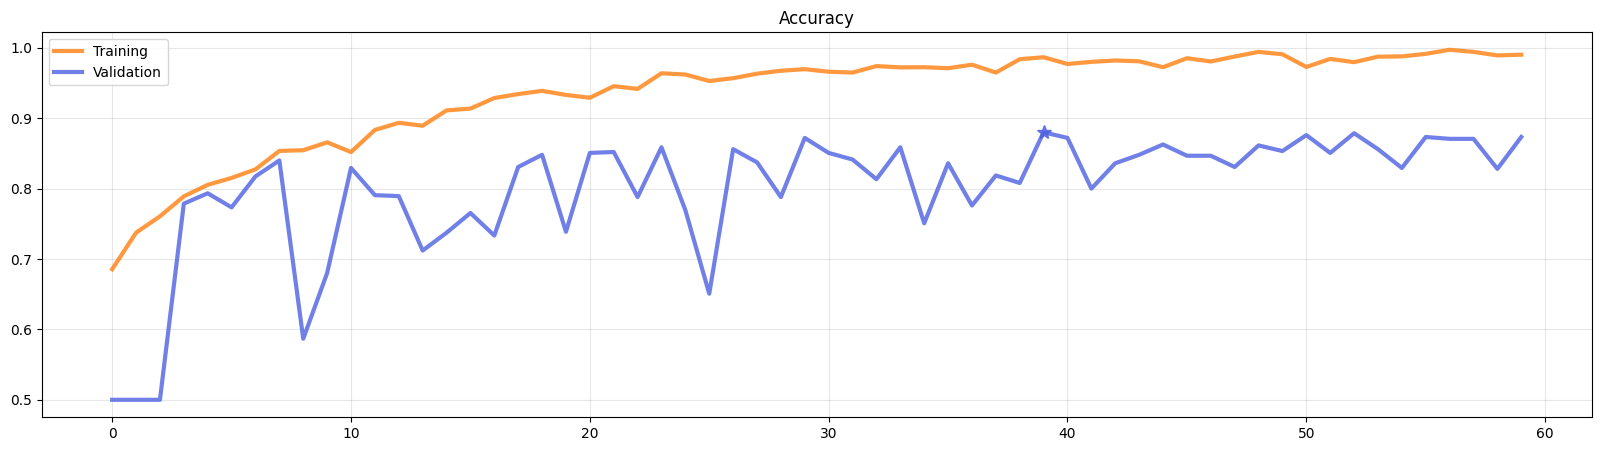

Accuracy Score over the Test Set: 0.8867



In [20]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.8867
Precision: 0.8868
Recall: 0.8867
F1: 0.8867


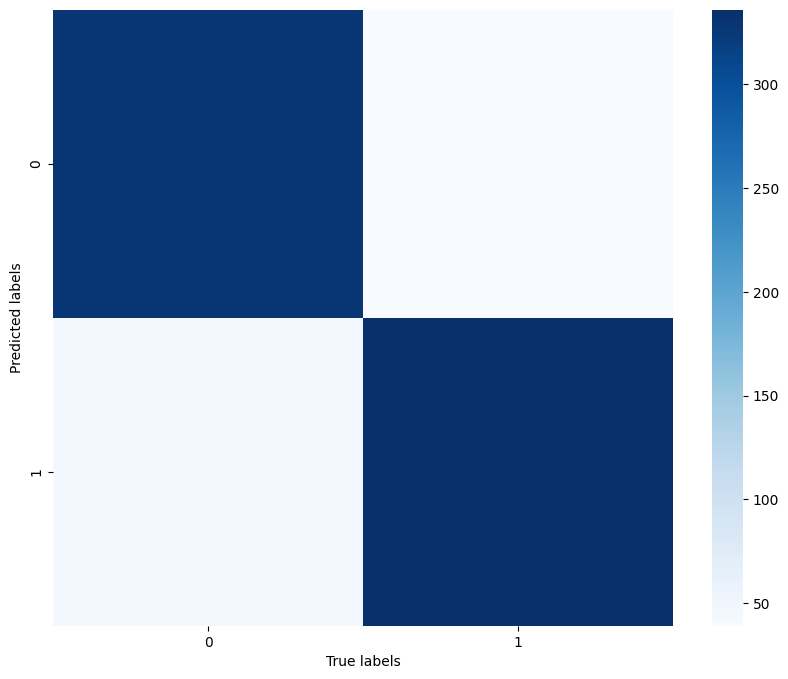

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Compute the confusion matrix
test_predictions = model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [23]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL

model.save('Batch_residual_VGG')

Mounted at /gdrive
/gdrive/My Drive/AN2DL
